# Neural Collapse and Data Distillatioin

This notebook implements a visualization page for the data distillation algorithm utilizing the neural collapse. 

The main papers considered here are 
 - data distillation:
     - https://github.com/SsnL/dataset-distillation 
     - https://github.com/google-research/google-research/tree/master/kip
 - Neural Collapse:
     - https://github.com/tding1/Neural-Collapse. 

The neural network has fixed the last layer weight matrix to be a simplex ETF. The ETF is a benign optimization landscape empeirically observed in practice as long as the network enters its terminal phase.

Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import *

from data.datasets import make_dataset
from Visualization import *

# Load Parameters

In [2]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-Adam-SOTA"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'CrossEntropy'
sample_size = None

# optimization
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: mps, Apple Silicon GPU


# Load Dataset

In [4]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class in our training set is ", num_classes)
print("Batch size: %d | Input size: %s" % (size_train,input_size))

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class in our training set is  10
Batch size: 64 | Input size: (32, 32, 3)


Let's visualize one image from the mini-batch.

In [5]:
random_sample_images_index(trainloader)


[1244, 28787, 9299, 21657, 27000, 23713, 40868, 26577, 11115, 14428]

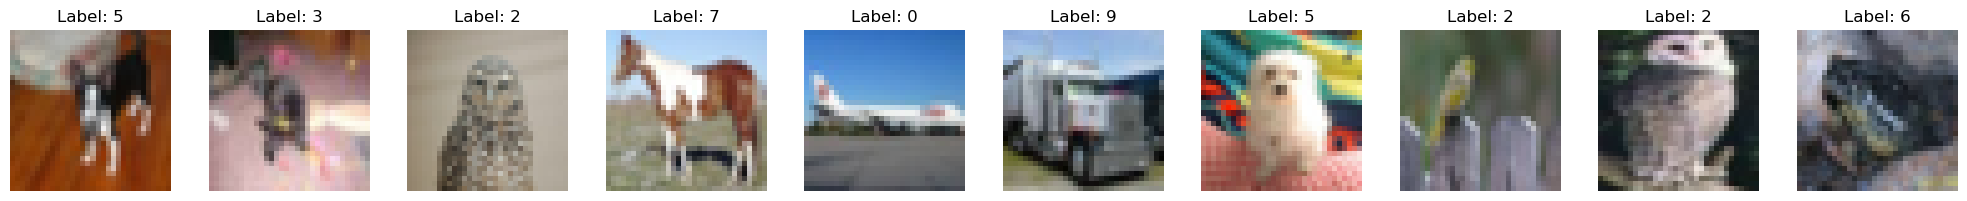

In [7]:
images,labels = random_sample_images(trainloader,seed=512)
visualize_images(images, labels)

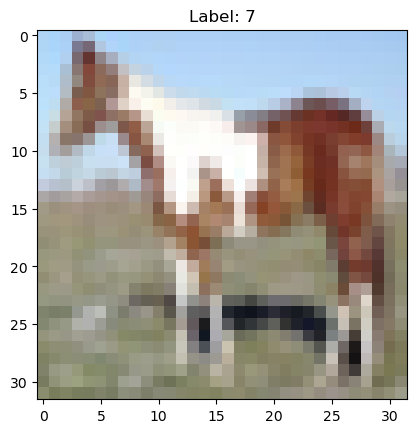

In [8]:
i = 3
image_to_plot = images[i].numpy().transpose(1, 2, 0)

# If the data was normalized, you may need to denormalize it
# image_to_plot = image_to_plot * std + mean  # Uncomment if needed

plt.imshow(image_to_plot)
plt.title(f'Label: {labels[i]}')
plt.show()

Let's visualize randomly selected one image per class.

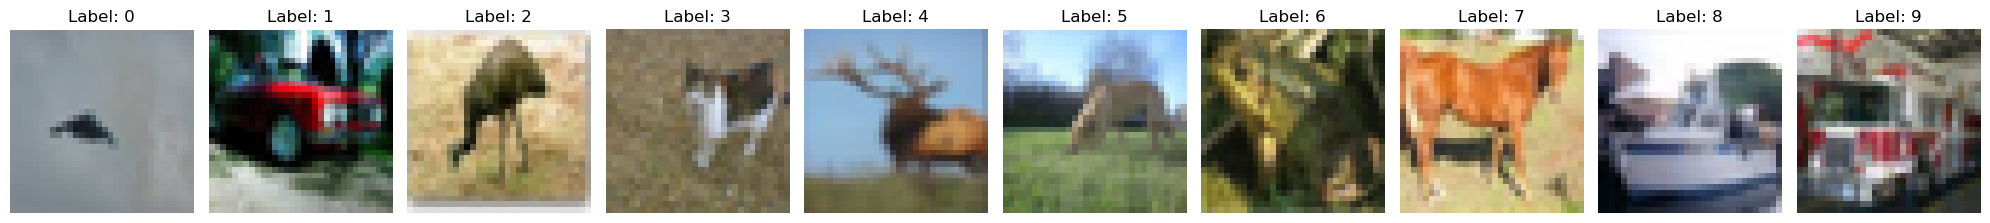

In [9]:
visualize_images_per_class_loader(trainloader, seed=1)

Let's compare the raw images and the transformed images (trainsformed images: above, raw images: below).

50000
10000


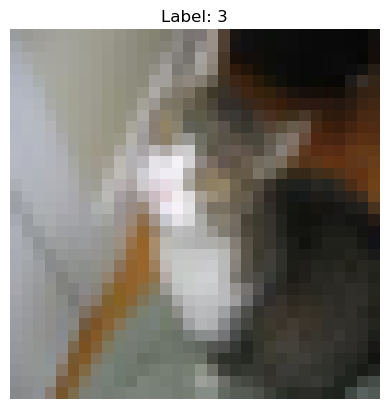

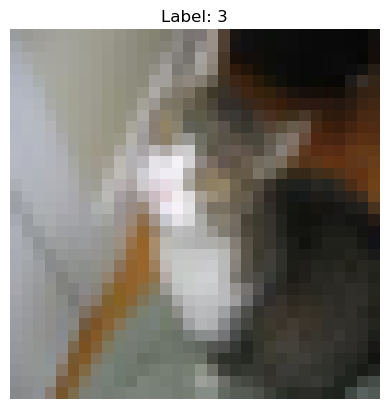

In [11]:
index = 101
trainset = trainloader.dataset
testset = testloader.dataset
print(len(trainset))
print(len(testset))

dataponit = trainset[index]  # This returns a tuple (image, label)
image, label = dataponit

image_to_plot = image.numpy().transpose(1, 2, 0)

# If the data was normalized, you may need to denormalize it
# image_to_plot = image_to_plot * std + mean  # Uncomment if needed

fig, ax = plt.subplots()  # Create a new figure and an axes.
ax.set_title(f'Label: {label}')
ax.imshow(image_to_plot)
ax.axis('off')  # Hide axis
# plt.imshow(image_to_plot)
# plt.show()

visualize_image_loader(trainloader, index=index, normalize_data=False)

## Raw Dataset with trainsformation

In [16]:
from torchvision.datasets import CIFAR10, MNIST

In [17]:
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
print('Dataset: CIFAR10.')
if SOTA:
    trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
        transforms.RandomCrop(size=32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
        ]))
else:
    trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ]))

testset = CIFAR10(root=data_dir, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ]))
num_classes = 10

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified


In [18]:
image, label = trainset[0]
print(torch.max(image),torch.min(image))

tensor(1.) tensor(0.)


In [19]:
for i in range(int(len(trainset)/10000)):
    dataponit = trainset[i]  # This returns a tuple (image, label)
    image, label = dataponit
    plt.imshow(image.transpose(1, 2, 0))
    plt.show()
    # imshow(image)


TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


# Load Model

In [8]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from arg_loader import *
from models.AE import Autoencoder
from torchsummary import summary

In [9]:
args = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

cudnn is used


In [10]:
if args.model == "MLP":
    Encoder = models.__dict__[args.model](hidden = args.width, depth = args.depth, fc_bias=args.bias, num_classes=num_classes).to(args.device)
elif args.model == "ResNet18_adapt":
    Encoder = ResNet18_adapt(width = args.width, num_classes=num_classes, fc_bias=args.bias).to(args.device)
else:
    Encoder = models.__dict__[args.model](num_classes=num_classes, fc_bias=args.bias, ETF_fc=args.ETF_fc, fixdim=args.fixdim, SOTA=args.SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(Encoder)))
print(type(Encoder))

# of model parameters: 8867442
<class 'models.resnet.ResNet'>


In [11]:
# architecture params
decoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-Adam-decoder"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'MSE'
sample_size = None

# optimization (change for autoencoder)
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

In [12]:
auto_args = train_args(model=decoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

cudnn is used


In [13]:
if auto_args.model == "MLP":
    Decoder = models.__dict__[args.model](hidden = auto_args.width, depth = auto_args.depth, fc_bias=auto_args.bias, num_classes=num_classes).to(auto_args.device)
elif auto_args.model == "ResNet18_adapt":
    Decoder = ResNet18_adapt(width = auto_args.width, num_classes=num_classes, fc_bias=auto_args.bias).to(auto_args.device)
else:
    Decoder = resnet_decode.__dict__[auto_args.model](num_classes=num_classes, fixdim=auto_args.fixdim, SOTA=auto_args.SOTA).to(auto_args.device)

print(type(Decoder))

<class 'models.resnet_decode.ResNet'>


In [15]:
autoencoder = Autoencoder(Encoder,Decoder)
autoencoder.freeze_encoder()
autoencoder.unfreeze_decoder()
print('# of model parameters: ' + str(count_network_parameters(autoencoder)))
print(type(autoencoder))
summary(autoencoder.to("cpu"), input_size=(3, 32, 32), device = "cpu")

# of model parameters: 8904554
<class 'models.AE.Autoencoder'>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64

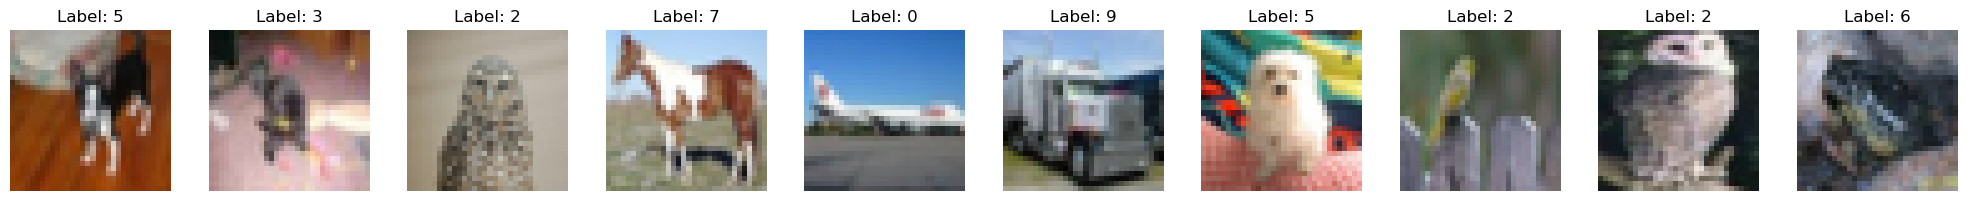

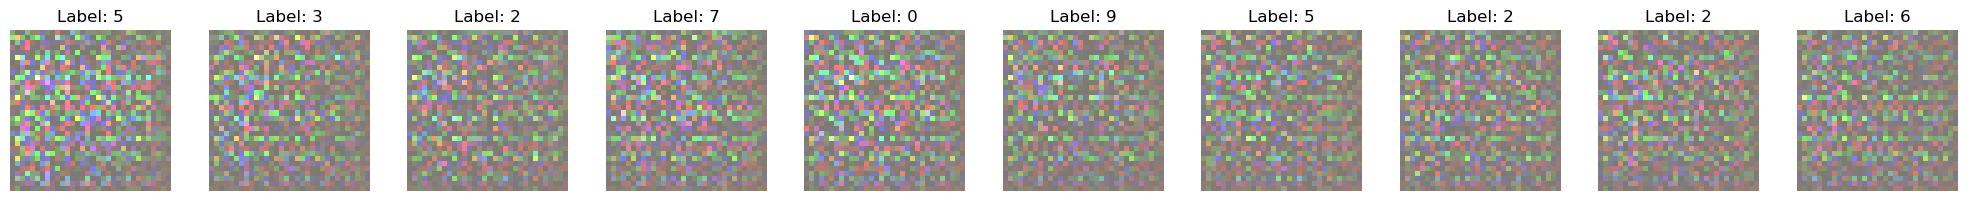

In [27]:
indices = random_sample_images_index(trainloader)
inputs, labels = images_from_index(trainloader.dataset, indices)
with torch.no_grad():
    outputs = autoencoder(inputs)
    visualize_images(inputs,labels)
    visualize_images(outputs,labels)

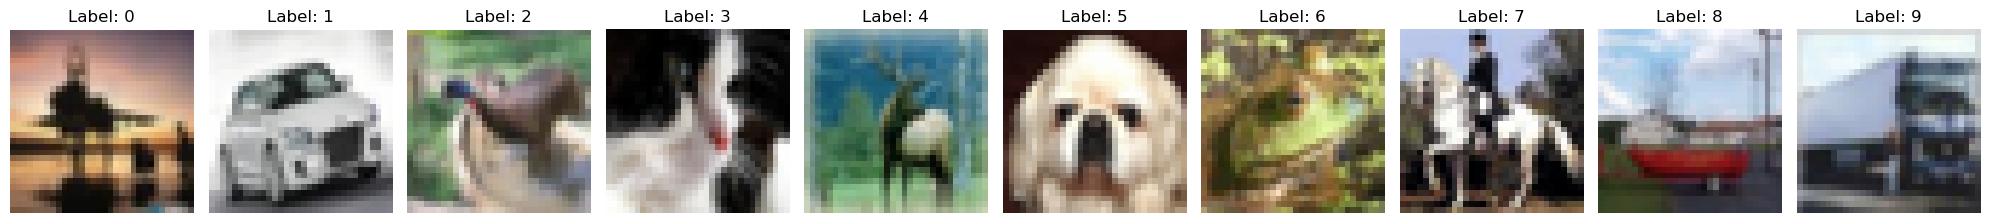

In [26]:
visualize_images_per_class_loader(testloader)

## The new dataset

In [29]:
from data.data_loading import get_cifar10_data_loaders

trainloader, testloader, traindataset, testdataset = get_cifar10_data_loaders(download=True, batch_size=batch_size)

100%|██████████| 170498071/170498071 [02:10<00:00, 1301885.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/Users/songzeyang/anaconda3/envs/mlenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


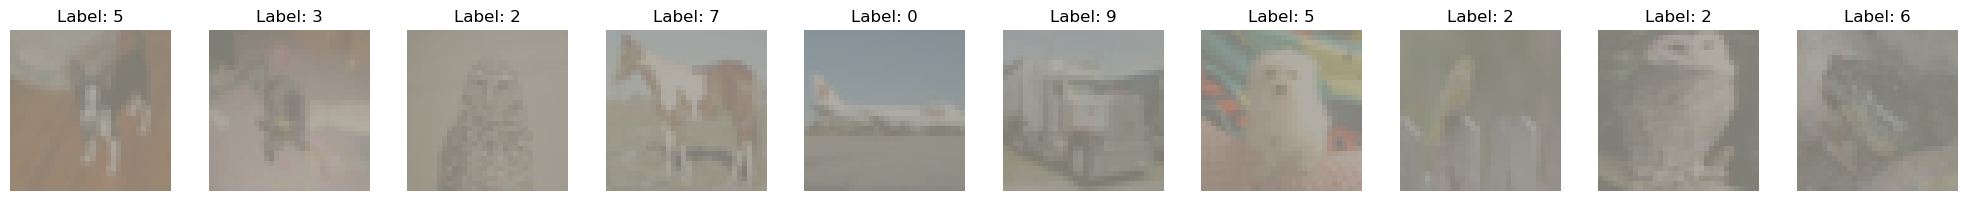

In [30]:
random_sample_images_index(trainloader)
images,labels = random_sample_images(trainloader,seed=512)
visualize_images(images, labels)

In [35]:
sample_image, label = trainloader.dataset[0]
print(sample_image)
print(torch.min(sample_image),torch.max(sample_image))

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.